In [1]:
import os
os.chdir('/vortexfs1/home/anthony.meza/Atmospheric Rivers and Waves/scripts')

In [34]:
from help_funcs import * 
import cartopy.crs as ccrs
import cartopy.feature as cfeature

import gsw

import pandas as pd
import xarray as xr
import numpy as np
import netCDF4 as nc

import cmocean.cm as cm
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns

from multiprocessing import Pool
import multiprocessing
from os.path import exists
from pathlib import Path
from natsort import natsorted
import importlib
from datetime import datetime


In [3]:
from dask_jobqueue import SLURMCluster  # setup dask cluster 
cluster = SLURMCluster(
    cores=36,
    processes=1,
    memory='192GB',
    walltime='02:00:00',
    queue='compute',
    interface='ib0')
print(cluster.job_script())
cluster.scale(jobs=4)
from dask.distributed import Client
client = Client(cluster)

#!/usr/bin/env bash

#SBATCH -J dask-worker
#SBATCH -p compute
#SBATCH -n 1
#SBATCH --cpus-per-task=36
#SBATCH --mem=179G
#SBATCH -t 02:00:00

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/bin/python -m distributed.cli.dask_worker tcp://172.16.3.62:46243 --nthreads 36 --memory-limit 178.81GiB --name dummy-name --nanny --death-timeout 60 --interface ib0



In [4]:
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://172.16.3.62:46243,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


In [5]:
def remove_seasonal(ds):
    climatology = ds.groupby("time.month").mean("time")
    anomalies = ds.groupby("time.month") - climatology
    return anomalies.drop("month")
def sigma0_from_SP_and_pt0(z, SP, pt0, lon = 0, lat = 30):
    p = gsw.p_from_z(-np.abs(z), lat)
    SA = gsw.SA_from_SP(SP, p, lon, lat)
    CT = gsw.CT_from_pt(SA,pt0)
    sigma0 = gsw.sigma0(SA,CT)
    return sigma0

def sigma0_on_xarray(ds):
    z = -ds.depth
    SP = ds.so
    pt0 = ds.thetao
    sigma0_ds = np.nan*ds.thetao.rename("sigma0")
    sigma0_ds.values = sigma0_from_SP_and_pt0(z, SP, pt0)

    return sigma0_ds

In [45]:
def _preprocess(ds):
    return ds[["thetao", "so"]].sel(latitude = slice(22, 35), longitude = slice(-122, -105))
def read_ds_ocn(ds): #very little memory footprint, 1 day = 500kib
        return ds[["thetao", "so"]].sel(latitude = slice(22, 35), longitude = slice(-122, -105)).sel(depth = 75, method = "nearest")
def read_GLORYS_subset(years):
    for year in years:
        print(year)
        files = np.empty(0, dtype = str)
        for month in months:
            file_path = GLORYS_dir + "/" + year + "/" + month
            file_list = natsorted([str(result) for result in list(Path(GLORYS_dir + "/" + year + "/" + month + "/").rglob("*.[nN][cC]"))])
            files = np.concatenate([files, file_list])
        files = natsorted([str(f) for f in files])
    
    dsets = xr.open_mfdataset(
            files,
            data_vars="minimal",
            coords="minimal",
            compat="override",
            preprocess=read_ds_ocn,
            parallel=True,
            chunks={"latitude":-1, "longitude":-1, "time":-1, "depth":-1},
            engine="scipy")
    
    return dsets

In [68]:
def plot_spatial_var(ax, data, LONS, LATS, bounds, levels):
    cf = ax.contourf(LONS, LATS, data, 
                      vmin = -bounds, vmax = bounds, levels = levels, 
                      cmap=cm.curl, extend = "both")
    ax.coastlines()
    gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True, alpha=0.0)
    gl.top_labels = False
    gl.right_labels = False
    return cf 

def animate_spatial_var(da, NINO_idx, event_name):

    data = da.values
    times = da.time.values
    times = pd.to_datetime(times).strftime('%Y-%m-%d')
    nt = len(times)

    fig,ax1 = plt.subplots(figsize = (5, 5),  subplot_kw = {"projection":ccrs.PlateCarree()})

    
    LONS, LATS = np.meshgrid(da.longitude, da.latitude)
    bounds = np.nanmax(np.abs(data))
    levels = np.linspace(-bounds, bounds, 21)

    cf = plot_spatial_var(ax1, data[0, :, :], LONS, LATS, bounds, levels)

    fig.colorbar(cf, fraction = 0.03, ax = ax1, orientation = "vertical")
    fig.suptitle("Potential Density Anomalies \n (Seasonal Cycle Removed)")
    fig.tight_layout()
    print(fig)
    def animate(i):
        ax1.clear(); 
        fontweight = "normal" if NINO_idx.values[i] < 0.5 else "bold"
        ax1.set_title(times[i] + "; NIÑO 3.4 = " + str(NINO_idx.values[i]), fontweight = fontweight)
        plot_spatial_var(ax1, data[i, :, :], LONS, LATS, bounds, levels)
        # ax2.clear(); 
        # ax2.plot(times, NINO_idx)
        # ax2.scatter(times[i], NINO_idx.values[i], c = "red")

    anim = FuncAnimation(fig, animate, blit=False)
    anim.save(event_name + '.mp4', writer='ffmpeg')

### Get NINO 3.4 Index

In [47]:
df = pd.read_csv("nino34.long.csv", index_col=0)
dates_df = df.astype("datetime64[D]")
for year in range(0, len(df.index)):
    for month in range(1, len(df.columns)+1):
        dates_df.iloc[year, month - 1] = np.datetime64(pd.Timestamp(df.index[year], month, 15), "D")
NINO34_ds = xr.DataArray(
            data=df.values.flatten(),
            dims=["time"],
            coords=dict(time=dates_df.values.flatten()))
NINO34 = NINO34_ds.sel(time = slice("1993", None))

/tmp/ipykernel_164237/1256711081.py:6: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  NINO34_ds = xr.DataArray(


### Make some anomaly movies 

In [48]:
GLORYS_dir = r"/vortexfs1/share/cdx/hseo/Data/MERCATOR/NEP_daily" 
results = [str(result) for result in list(Path(GLORYS_dir).rglob("*.[nN][cC]"))] #get all files
results = natsorted(results) #sort all files 

years = natsorted(list(set([result[41:45] for result in results])))
months = natsorted(['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12'])

In [80]:
ds = xr.open_mfdataset(
            results[0:620],
            data_vars="minimal",
            coords="minimal",
            compat="override",
            preprocess=read_ds_ocn,
            parallel=True,
            chunks={"latitude":-1, "longitude":-1, "time":-1},
            engine="scipy")
ds = ds.convert_calendar('noleap') #remove leap years from operations
ds_climatology = ds.groupby("time.dayofyear").mean("time").compute()

/vortexfs1/home/anthony.meza/mambaforge/envs/atm_rivers/lib/python3.10/site-packages/distributed/client.py:3095: UserWarning: Sending large graph of size 15.13 MiB.
This may cause some slowdown.
Consider scattering data ahead of time and using futures.
  warnings.warn(


In [50]:
%%time 
all_years = [["1997", "1998", "1999"], ["2001", "2002", "2003"],
             ["2005", "2006", "2007"], ["2008", "2009", "2010"],
             ["2014", "2015", "2016"]]

all_slices = [slice("1997", "1999.4"), slice("2001.5", "2003"),
              slice("2005.5", "2007"), slice("2008.7", "2010"),
              slice("2014", "2016")]

all_events = ["97Nino", "02Nino", 
              "06Nino", "09Nino", 
              "15Nino"]
nevents = len(all_events)

CPU times: user 8 µs, sys: 3 µs, total: 11 µs
Wall time: 16.2 µs


In [71]:
def animate_years(yrs, time_slice, event_name):
    NINO_ds = read_GLORYS_subset(yrs)

    sigma0_NINO =  sigma0_on_xarray(NINO_ds).compute()
    sigma0_NINO = sigma0_NINO.convert_calendar('noleap')
    
    #compute monthly anomalies 
    anomalies = sigma0_NINO.groupby("time.dayofyear") - sigma0_climatology
    sigma0_NINO_anom = anomalies.drop("dayofyear") 
    reindex_datetimes = [datetime.strptime(str(date), '%Y-%m-%d %H:%M:%S') for date in sigma0_NINO_anom.time.values]
    sigma0_NINO_anom["time"] = reindex_datetimes

    sigma0_NINO_anom = sigma0_NINO_anom.sel(time = time_slice)
    return sigma0_NINO_anom
    #get 
    NINO34_sub = remove_seasonal(NINO34).interp(time = sigma0_NINO_anom.time)
    NINO34_sub = np.round(NINO34_sub, decimals = 2).sel(time = time_slice)

    #animate
    animate_spatial_var(sigma0_NINO_anom, NINO34_sub, event_name)

In [72]:
i = 0
yrs = all_years[i]; time_slice=all_slices[i]; event_name = all_events[i]
print(event_name)
#read in years
ds = animate_years(yrs, time_slice, event_name + "test")

97Nino
1997
1998
1999


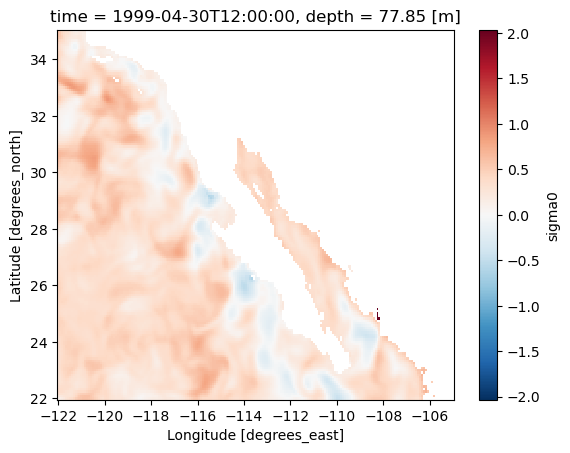

In [76]:
ds.isel(time = -1).plot()

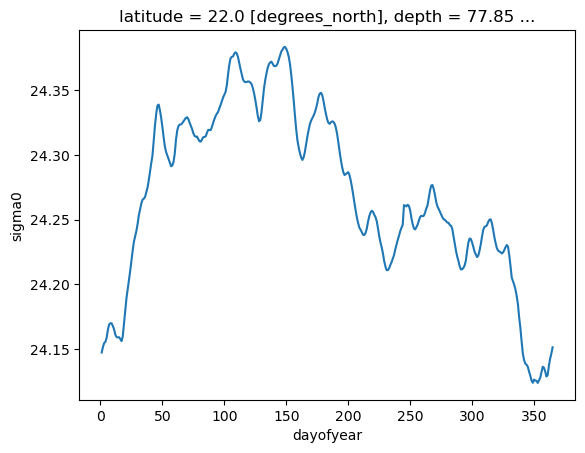

In [81]:
sigma0_climatology.isel(latitude = 0, longitude = 0).plot()